In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

In [2]:
def load_data(path):
    data = np.loadtxt(path)
    labels = data[:, 0].astype(int)
    features = data[:, 1:]
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    return features, labels

In [3]:
def visualize_digit(X, y):
    img_indices = [np.argwhere(y == i)[0, 0] for i in range(10)]  
    plt.figure(figsize=(10, 3))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img_index = img_indices[i]
        plt.imshow(X[img_index, :].reshape(16, 16), cmap='plasma') 
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def train_test_split(X, y, test_size=0.2, random_state=None):

    max_samples = 300
    X = X[:max_samples]
    y = y[:max_samples]
  
    n_samples = len(X)
    if random_state is not None:
        rng = np.random.default_rng(random_state)  
        indices = rng.permutation(n_samples) 
    else:
        indices = np.random.permutation(n_samples)  

    split_idx = int(n_samples * (1 - test_size))
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [5]:
class KernelPerceptron:
    def __init__(self, kernel):
        self.kernel = kernel
        self.alpha = []
        self.support_vectors = []
        self.support_labels = []
    
    def fit(self, X, y, epochs=3):
        print("begin fit")
        n_samples = len(y)
        self.alpha = np.zeros(n_samples)
        for epoch in range(epochs): # repeat whole set
            for t in range(n_samples):
                print(f"fit epoch{epoch}.{t}")
                prediction = np.sign(np.sum(self.alpha*y*self.kernel(X, X[t])))
                if prediction != y[t]:
                    self.alpha[t] = y[t]
                    if X[t].tolist() not in [sv.tolist() for sv in self.support_vectors]:
                        self.support_vectors.append(X[t]) # item not in this class
                        self.support_labels.append(y[t]) # otherwise as 0
        

    def predict(self, X):
        predictions = []
        for x in X:
            score = np.sum(
                [
                    alpha * label * self.kernel(support_vector, x)
                    for alpha, support_vector, label in zip(
                        self.alpha, self.support_vectors, self.support_labels
                    )
                ]
            )
            print(f"score{score}")
            predictions.append(np.sign(score))
        return np.array(predictions)

In [6]:
def polynomial_kernel(X, Y, degree=3):
    return np.dot(X, Y.T)**degree

def gaussian_kernel(X, Y, sigma=1.0):
    X_norm = np.sum(X**2, axis=1).reshape(-1, 1)  
    Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)  
    dist_squared = X_norm + Y_norm - 2 * np.dot(X, Y.T)  
    return  np.exp(-dist_squared / (2 * sigma**2))  

In [7]:
def one_vs_rest(X_train, y_train, X_test, k, kernel, epochs=3):
    classifiers = []
    for c in range(k):
        y_binary = np.where(y_train == c, 1, -1) # change the original tag into binary
        classifier = KernelPerceptron(kernel)
        classifier.fit(X_train, y_binary, epochs=epochs)
        classifiers.append(classifier)

    confidence_scores = np.array([clf.predict(X_test) for clf in classifiers])
    predictions = np.argmax(confidence_scores, axis=0)
    return predictions

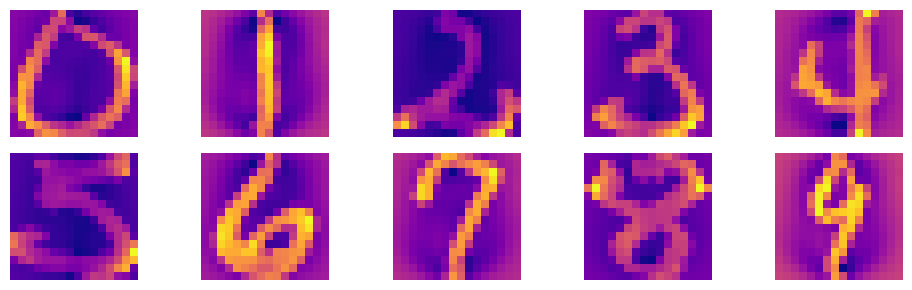

Run 1/20...
Training with polynomial degree 1 (1/7)...
begin fit
fit epoch0.0
fit epoch0.1
fit epoch0.2
fit epoch0.3
fit epoch0.4
fit epoch0.5
fit epoch0.6
fit epoch0.7
fit epoch1.0
fit epoch1.1
fit epoch1.2
fit epoch1.3
fit epoch1.4
fit epoch1.5
fit epoch1.6
fit epoch1.7
fit epoch2.0
fit epoch2.1
fit epoch2.2
fit epoch2.3
fit epoch2.4
fit epoch2.5
fit epoch2.6
fit epoch2.7
Finished training for degree 1.
begin fit
fit epoch0.0
fit epoch0.1
fit epoch0.2
fit epoch0.3
fit epoch0.4
fit epoch0.5
fit epoch0.6
fit epoch0.7
fit epoch1.0
fit epoch1.1
fit epoch1.2
fit epoch1.3
fit epoch1.4
fit epoch1.5
fit epoch1.6
fit epoch1.7
fit epoch2.0
fit epoch2.1
fit epoch2.2
fit epoch2.3
fit epoch2.4
fit epoch2.5
fit epoch2.6
fit epoch2.7
begin fit
fit epoch0.0
fit epoch0.1
fit epoch0.2
fit epoch0.3
fit epoch0.4
fit epoch0.5
fit epoch0.6
fit epoch0.7
fit epoch1.0
fit epoch1.1
fit epoch1.2
fit epoch1.3
fit epoch1.4
fit epoch1.5
fit epoch1.6
fit epoch1.7
fit epoch2.0
fit epoch2.1
fit epoch2.2
fit epoch2.3

In [8]:

def q3_experiment(path="data/zipcombo.dat.txt", 
                  degrees=[1, 2, 3, 4, 5, 6, 7], 
                  runs=20, 
                  epochs=3):
    
    X, y = load_data(path)
    visualize_digit(X, y)

    n_degrees = len(degrees)
    num_classes = len(np.unique(y))

    train_errors = np.zeros((runs, n_degrees))
    test_errors = np.zeros((runs, n_degrees))

    for run in range(runs):
        print(f"Run {run + 1}/{runs}...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=run)
        
        for idx, degree in enumerate(degrees):
            print(f"Training with polynomial degree {degree} ({idx + 1}/{n_degrees})...")
            kernel = lambda X, Y: polynomial_kernel(X, Y, degree)
            perceptron = KernelPerceptron(kernel)
            
            # Train the perceptron
            perceptron.fit(X_train, y_train, epochs=epochs)
            print(f"Finished training for degree {degree}.")
            
            # Predict and compute errors
            y_train_pred = one_vs_rest(X_train, y_train, X_train, num_classes, kernel, epochs=epochs)
            y_test_pred = one_vs_rest(X_train, y_train, X_test, num_classes, kernel, epochs=epochs)
            
            train_errors[run, idx] = np.mean(y_train_pred != y_train)
            test_errors[run, idx] = np.mean(y_test_pred != y_test)

            print(f"Train Error={train_errors[run, idx]:.10f}, Test Error={test_errors[run, idx]:.10f}.")
    
    
    train_mean = np.mean(train_errors, axis=0)
    train_std = np.std(train_errors, axis=0)
    test_mean = np.mean(test_errors, axis=0)
    test_std = np.std(test_errors, axis=0)

    print("Train Error (Mean ± Std):")
    for d, mean, std in zip(degrees, train_mean, train_std):
        print(f"d={d}: {mean:.10f} ± {std:.10f}")
    
    print("\nTest Error (Mean ± Std):")
    for d, mean, std in zip(degrees, test_mean, test_std):
        print(f"d={d}: {mean:.10f} ± {std:.10f}")
    
    return 

if __name__ == "__main__":
    q3_experiment()